### Import Necessary Packages

In [25]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras import models, layers, optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow import keras
from keras.applications import MobileNet
from keras.models import Sequential
from keras.layers import Dense,Flatten,BatchNormalization,Dropout

### Load the data

In [45]:
# The folder containing the zip file
base_dir = r'C:/Users/HP/Desktop/Python_Projects/Data_Science_Projects/AI Face Recognition'

# The directory path
path_dir = r'C:/Users/HP/Desktop/Python_Projects/Data_Science_Projects/AI Face Recognition/Faces'
# Paths to zip file
faces_zip_path = os.path.join(base_dir, 'Faces.zip')

# Extract datasets
with zipfile.ZipFile(faces_zip_path, 'r') as zip_faces:
    zip_faces.extractall(base_dir)



# The folder where images are extracted 
faces_image_dir = os.path.join(base_dir, 'Faces')
  


# List image filename 
faces_filenames = os.listdir(faces_image_dir)


# Create labels based on filenames 
faces_labels = [x.split(".")[0] for x in faces_filenames]


# Create DataFrames
faces_df = pd.DataFrame({"filename": faces_filenames, "label": faces_labels})

### EDA

In [50]:
# List the directories 
dir_list = os.listdir(path_dir)
os.listdir(path_dir)

['Akshay Kumar', 'Alexandra Daddario', 'Alia Bhatt', 'Amitabh Bachchan', 'Andy Samberg', 'Anushka Sharma', 'Billie Eilish', 'Brad Pitt', 'Camila Cabello', 'Charlize Theron', 'Claire Holt', 'Courtney Cox', 'Dwayne Johnson', 'Elizabeth Olsen', 'Ellen Degeneres', 'Henry Cavill', 'Hrithik Roshan', 'Hugh Jackman', 'Jessica Alba', 'Kashyap', 'Lisa Kudrow', 'Margot Robbie', 'Marmik', 'Natalie Portman', 'Priyanka Chopra', 'Robert Downey Jr', 'Roger Federer', 'Tom Cruise', 'Vijay Deverakonda', 'Virat Kohli', 'Zac Efron']


In [4]:
# Function to display some images
def sample_images(df, image_dir, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        random_index = df.sample()['filename'].values[0]
        img_path = os.path.join(image_dir, random_index)
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(df[df['filename'] == random_index]['label'].values[0])
    plt.show()

# Data Overview
print("Number of images:", len(faces_df))
print("Number of unique classes:", len(faces_df['label'].unique()))

Number of images: 2562
Number of unique classes: 2562


There are 2562 images in the dataset with each belonging to a unique class.

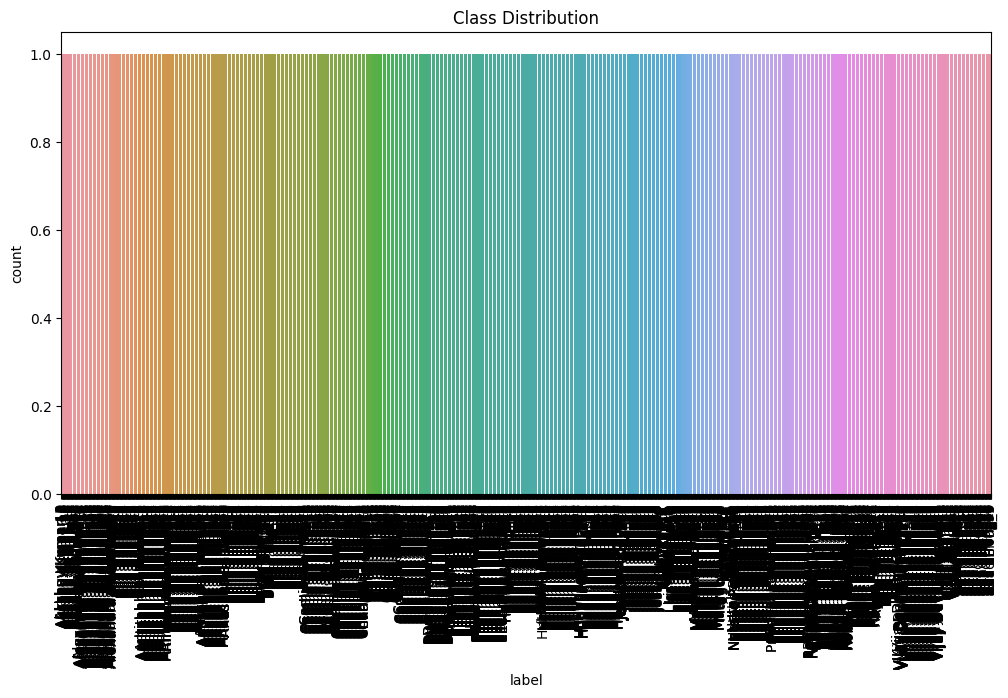

In [5]:
# Class Distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=faces_df, x='label')
plt.xticks(rotation=90)
plt.title('Class Distribution')
plt.show()

In [6]:

# Image Analysis
img_sizes = []
for filename in faces_df['filename']:
    img_path = os.path.join(faces_image_dir, filename)
    img = Image.open(img_path)
    img_sizes.append(img.size)

img_sizes_df = pd.DataFrame(img_sizes, columns=['Width', 'Height'])
print("Image Size Summary:")
print(img_sizes_df.describe())

Image Size Summary:
        Width  Height
count  2562.0  2562.0
mean    160.0   160.0
std       0.0     0.0
min     160.0   160.0
25%     160.0   160.0
50%     160.0   160.0
75%     160.0   160.0
max     160.0   160.0


The summary statistics shows that dataset have the same image size. Each image has a width and height of 160 pixels. The uniformity in image size suggesting consistency across the images hence there is no variability in the dataset.

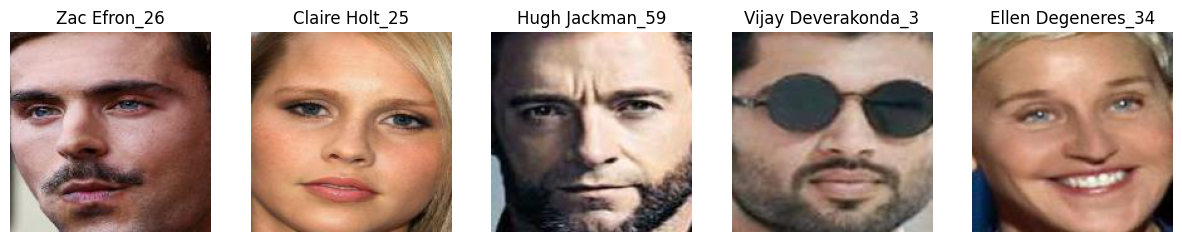

In [7]:
# Display Sample Images
sample_images(faces_df, faces_image_dir)

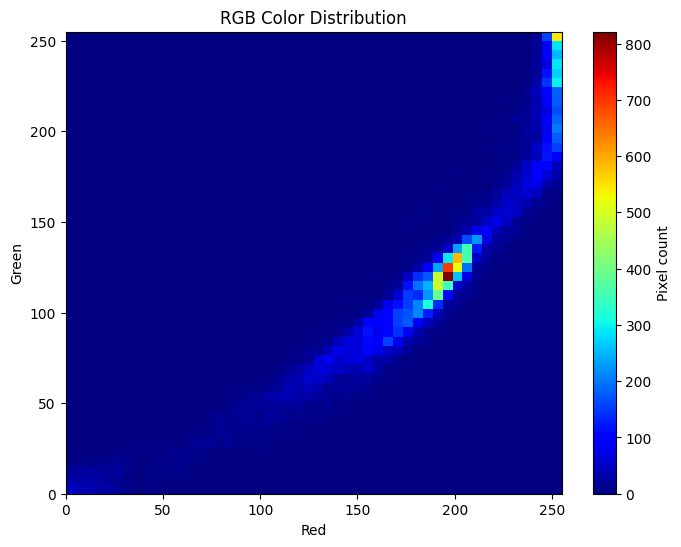

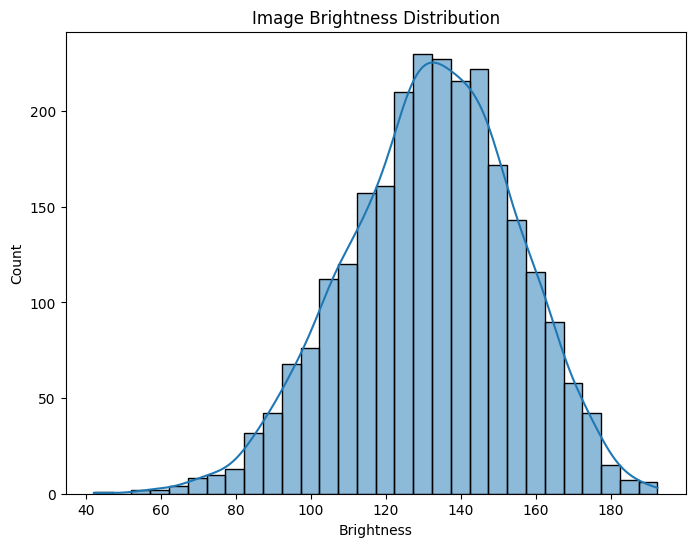

In [8]:
# Image Color Analysis
def plot_color_distribution(image_dir, filename):
    img_path = os.path.join(image_dir, filename)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    colors = img_rgb.reshape(-1, 3)
    plt.figure(figsize=(8, 6))
    plt.hist2d(colors[:, 0], colors[:, 1], bins=(50, 50), cmap=plt.cm.jet)
    plt.colorbar(label='Pixel count')
    plt.xlabel('Red')
    plt.ylabel('Green')
    plt.title('RGB Color Distribution')
    plt.show()

# Image Quality Assessment 
def image_brightness(image_dir, filename):
    img_path = os.path.join(image_dir, filename)
    img = cv2.imread(img_path)
    brightness = np.mean(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    return brightness

# 5. Image Color Analysis
plot_color_distribution(faces_image_dir, faces_df.sample()['filename'].values[0])


# 7. Image Quality Assessment
brightness_values = [image_brightness(faces_image_dir, filename) for filename in faces_df['filename']]
plt.figure(figsize=(8, 6))
sns.histplot(brightness_values, bins=30, kde=True)
plt.title('Image Brightness Distribution')
plt.xlabel('Brightness')
plt.ylabel('Count')
plt.show()

Image brightness distribution is approximately normal.

### Building the Model

In [74]:

data_gen=keras.preprocessing.image.ImageDataGenerator(zoom_range=0.1,
                           horizontal_flip=True,
                           vertical_flip=False,
                           width_shift_range=0.1,
                           height_shift_range=0.1,
                           validation_split=0.2,
                           rescale=1./255)
train_ds=data_gen.flow_from_directory(path_dir,target_size=(256,256),class_mode='categorical',subset='training',batch_size=32)

valid_ds=data_gen.flow_from_directory(path_dir,target_size=(256,256),class_mode='categorical',subset='validation',batch_size=32)


Found 1210 images belonging to 31 classes.
Found 273 images belonging to 31 classes.


In [85]:
from keras.layers import GlobalAveragePooling2D

base_model = MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    BatchNormalization(momentum=0.99, epsilon=0.001),
    Dropout(0.2),
    Dense(64, activation='relu'),
    BatchNormalization(momentum=0.99, epsilon=0.001),
    Dropout(0.2),
    Dense(31, activation='softmax')
])

model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Train the model
history = model.fit(train_ds, validation_data=valid_ds, epochs=25)


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_63 (Dense)            (None, 128)               131200    
                                                                 
 batch_normalization_42 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dropout_42 (Dropout)        (None, 128)               0         
                                                     

### Evaluation

In [88]:
# Evaluate the model 
test_loss, test_accuracy = model.evaluate(valid_ds)
# Print the test accuracy
print('Test accuracy:', test_accuracy)

9/9 [==============================] - 6s 653ms/step - loss: 0.7095 - accuracy: 0.7729
Test accuracy: 0.7728937864303589


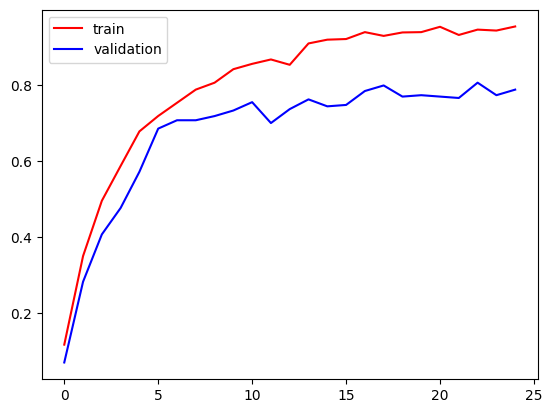

In [86]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

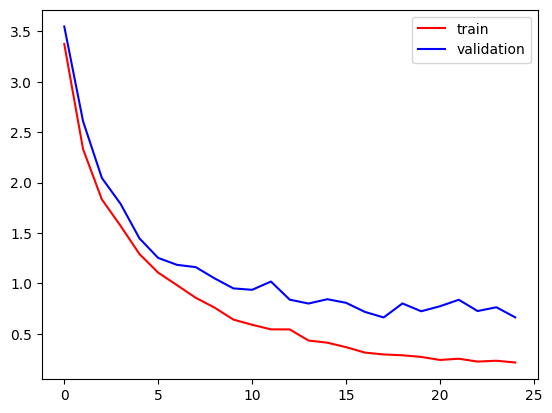

In [93]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

### Predictions

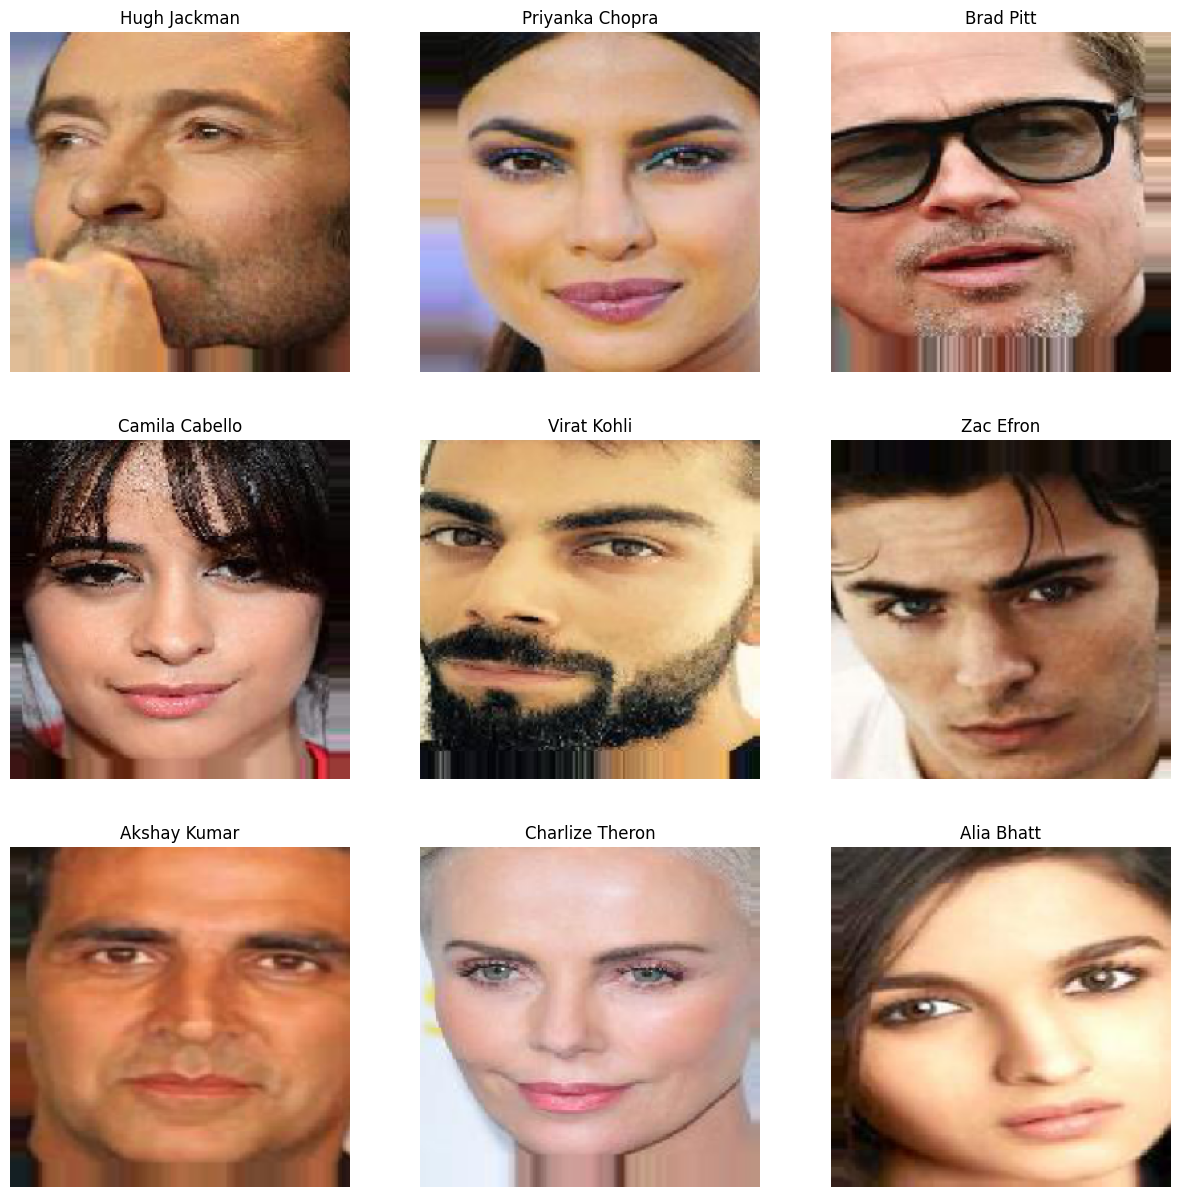

In [100]:
import matplotlib.pyplot as plt

# Get the class labels
class_labels = train_ds.class_indices
class_labels = dict((v, k) for k, v in class_labels.items())

# Display the images and their labels
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i in range(9):
    images, labels = valid_ds.next()
    image = images[0]  # Take the first image from the batch
    label = np.argmax(labels[0])  # Get the label index
    label = class_labels[label]  # Convert label index to label name
    ax[i//3, i%3].imshow(image)
    ax[i//3, i%3].set_title(label)
    ax[i//3, i%3].axis('off')
plt.show()


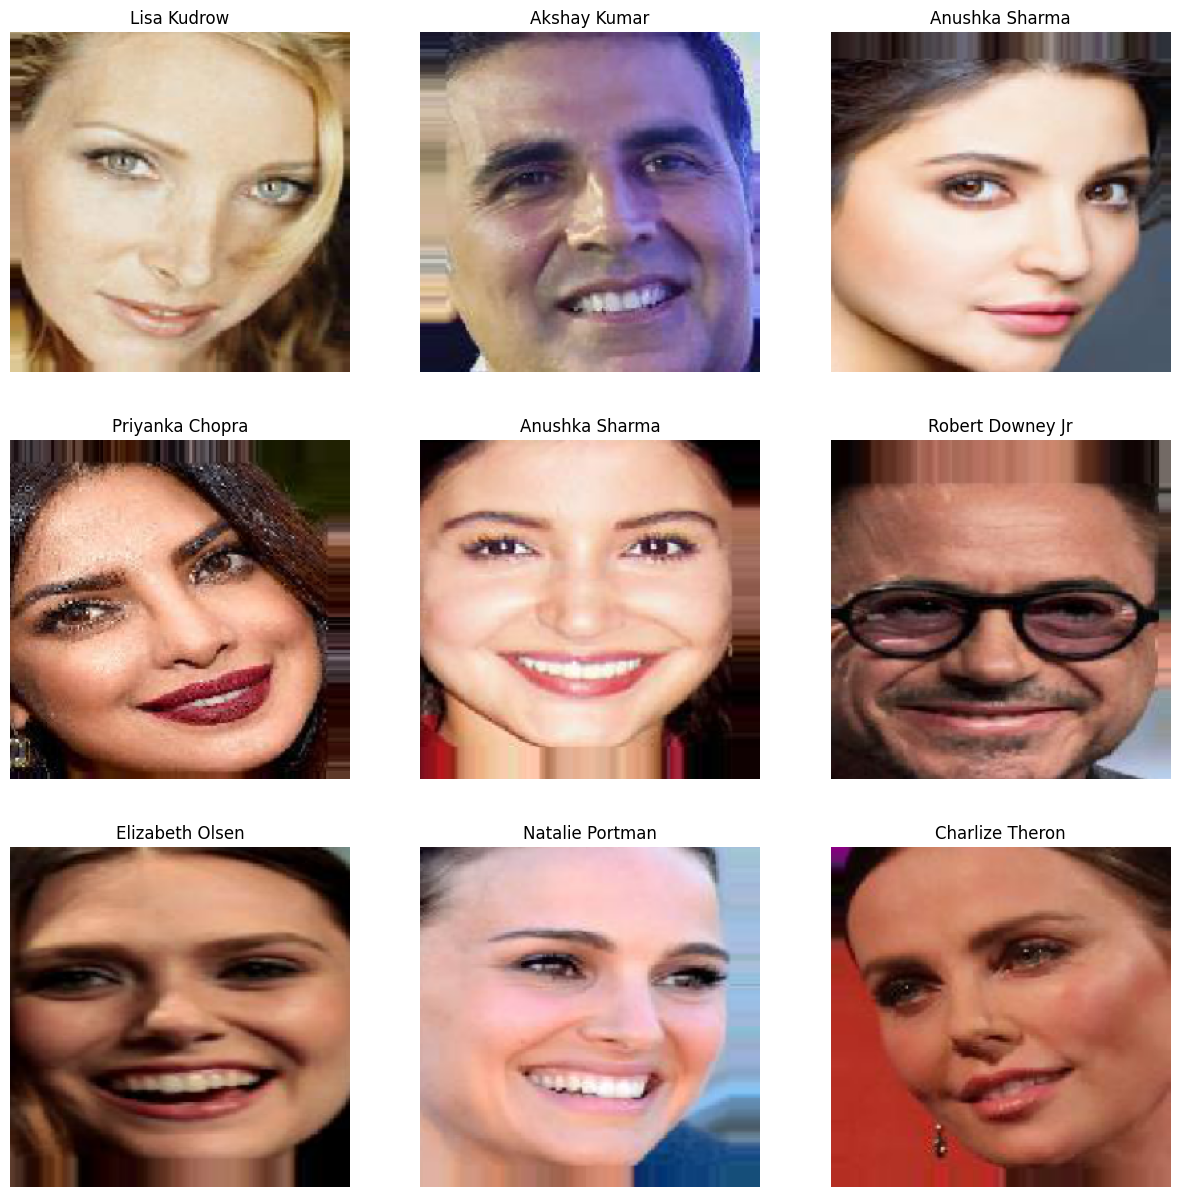

In [99]:
import matplotlib.pyplot as plt

# Get the class labels
class_labels = train_ds.class_indices
class_labels = dict((v, k) for k, v in class_labels.items())

# Display the images and their labels
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i in range(9):
    x, y = valid_ds.next()
    image = x[0]
    label = y[0]
    label = np.argmax(label)
    label = class_labels[label]
    ax[i//3, i%3].imshow(image)
    ax[i//3, i%3].set_title(label)
    ax[i//3, i%3].axis('off')
plt.show()


1/1 [==============================] - 0s 49ms/step


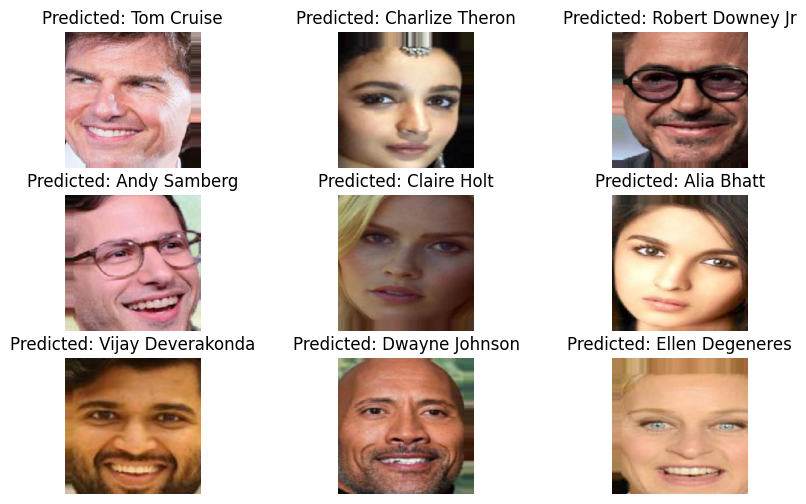

In [104]:
import matplotlib.pyplot as plt
import numpy as np

# Get the class labels
class_labels = train_ds.class_indices
class_labels = dict((v, k) for k, v in class_labels.items())

# Display the images and their predicted labels
fig, ax = plt.subplots(3, 3, figsize=(10, 6))
for i in range(9):
    x, y = valid_ds.next()
    image = x[0]
    label = y[0]
    # Get the predicted label
    pred = model.predict(np.expand_dims(image, axis=0))
    pred_label = np.argmax(pred)
    pred_label = class_labels[pred_label]
    ax[i//3, i%3].imshow(image)
    ax[i//3, i%3].set_title(f'Predicted: {pred_label}')
    ax[i//3, i%3].axis('off')
plt.show()